# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

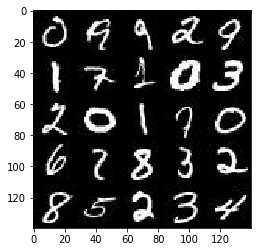

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

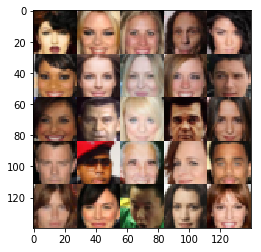

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse) as discriminator_scope:
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*512)

        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    steps, print_every = 0, 100

    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2

                sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})

                if steps % 10 == 0:
                # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)


                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1251... Generator Loss: 0.0472
Epoch 1/2... Discriminator Loss: 3.7595... Generator Loss: 0.2137
Epoch 1/2... Discriminator Loss: 2.1287... Generator Loss: 0.6806
Epoch 1/2... Discriminator Loss: 1.9748... Generator Loss: 0.5350
Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 1.1069
Epoch 1/2... Discriminator Loss: 1.5592... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.6780... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 2.1018... Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.7972


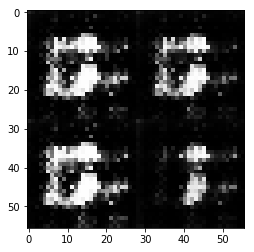

Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 1.2477
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.8361
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 1.9104... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.4787... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.8094
Epoch 1/2... Discriminator Loss: 1.6706... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 2.0645... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.8530
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 0.7897


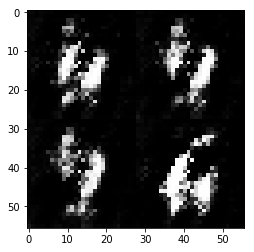

Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.6141... Generator Loss: 0.5897
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.6658
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.5291... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.6824... Generator Loss: 0.6006
Epoch 1/2... Discriminator Loss: 1.5665... Generator Loss: 0.6741
Epoch 1/2... Discriminator Loss: 1.7072... Generator Loss: 0.6315


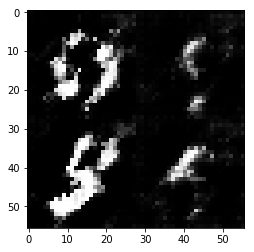

Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.4604... Generator Loss: 0.7605
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.4912... Generator Loss: 0.6478
Epoch 1/2... Discriminator Loss: 1.5465... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 1.2969... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.8108


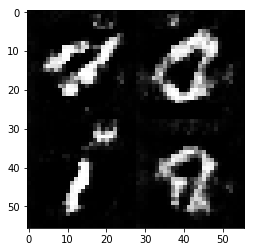

Epoch 1/2... Discriminator Loss: 1.3974... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.7324
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.5125... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.5622
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.7339
Epoch 2/2... Discriminator Loss: 1.4884... Generator Loss: 0.6016
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.7399


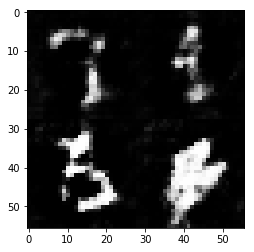

Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5715
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.5690... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.5149... Generator Loss: 1.1220
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.9715
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7171


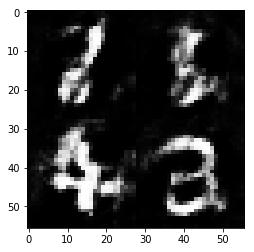

Epoch 2/2... Discriminator Loss: 1.5736... Generator Loss: 0.9643
Epoch 2/2... Discriminator Loss: 1.4272... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.4136... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 1.4864... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 1.4213... Generator Loss: 0.6065
Epoch 2/2... Discriminator Loss: 1.4316... Generator Loss: 0.5481
Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 0.7819


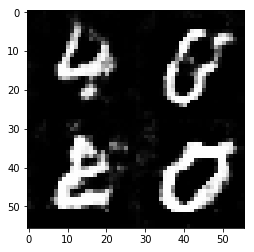

Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.9448
Epoch 2/2... Discriminator Loss: 1.4643... Generator Loss: 0.7266
Epoch 2/2... Discriminator Loss: 1.5022... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 1.4137... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.4785... Generator Loss: 0.8677
Epoch 2/2... Discriminator Loss: 1.5105... Generator Loss: 0.5011
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 0.5168
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.4745... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 1.4370... Generator Loss: 0.5829


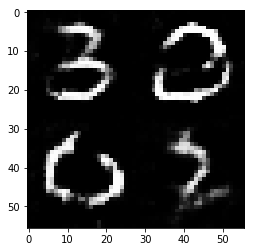

Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.4866... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.8675
Epoch 2/2... Discriminator Loss: 1.4532... Generator Loss: 0.4955
Epoch 2/2... Discriminator Loss: 1.6032... Generator Loss: 0.3618
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.5207... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.4891... Generator Loss: 0.7861
Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 1.4975... Generator Loss: 0.4531


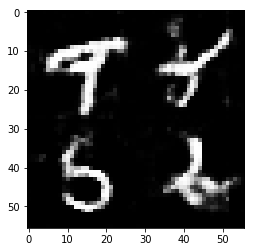

Epoch 2/2... Discriminator Loss: 1.4131... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.5011... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 1.4450... Generator Loss: 0.6171


In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.6587... Generator Loss: 0.0039
Epoch 1/1... Discriminator Loss: 3.9237... Generator Loss: 0.1646
Epoch 1/1... Discriminator Loss: 3.7005... Generator Loss: 0.1487
Epoch 1/1... Discriminator Loss: 2.4005... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 2.7728... Generator Loss: 0.2770
Epoch 1/1... Discriminator Loss: 3.0836... Generator Loss: 0.1677
Epoch 1/1... Discriminator Loss: 2.0152... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 2.2375... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 2.2265... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.9351... Generator Loss: 0.5743


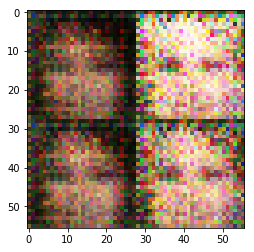

Epoch 1/1... Discriminator Loss: 2.8024... Generator Loss: 0.2393
Epoch 1/1... Discriminator Loss: 2.2249... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.6888... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.7910... Generator Loss: 0.4939
Epoch 1/1... Discriminator Loss: 2.1742... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.6589... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.6332... Generator Loss: 0.5544


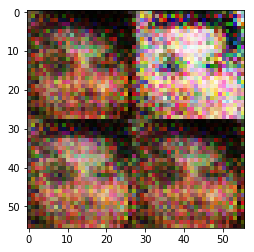

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.7131... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.7998... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.8010... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6502


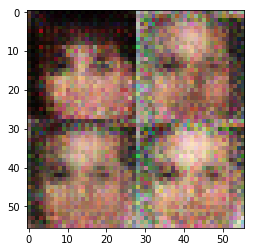

Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.8924... Generator Loss: 0.3831
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.5480
Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.6706


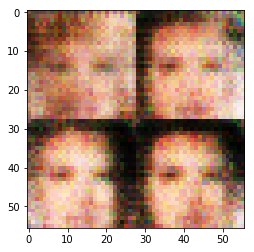

Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.6743


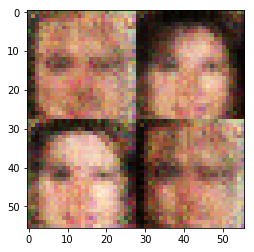

Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.6032... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.6883... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.6381


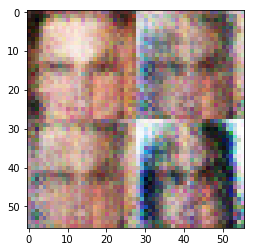

Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6651


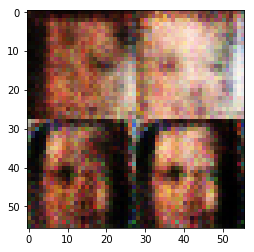

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6582


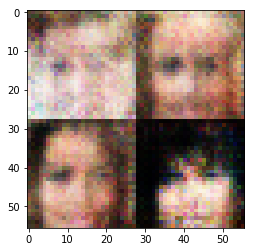

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6004


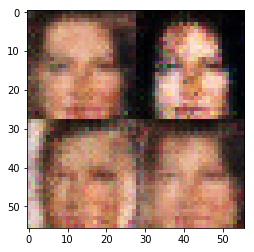

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6480


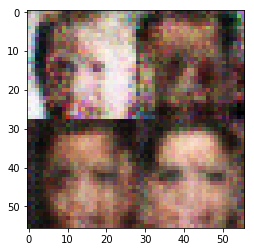

Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.6907


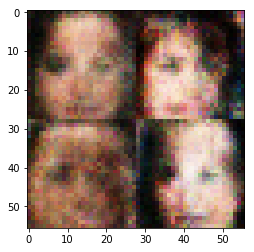

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6088


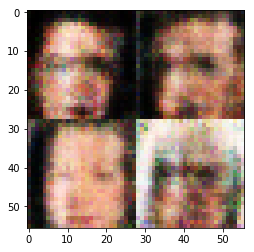

Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6215


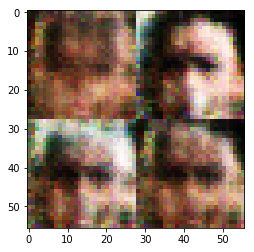

Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7041


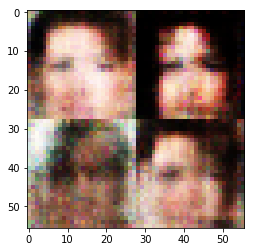

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.6398


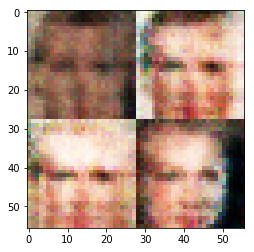

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6769


In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.